Author: Zidong Chen<br />
Date: 2021/10/12<br />
Acknowledgement: This idea is from Wei W. Xing (wxing.me)<br />
Introduction: This notebook is to show how to use eigen decomposition to solve the non-positive definite problem in Gaussian Process (GP) regression.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
from core.kernel import ARDKernel
import core.GP_CommonCalculation as GP

In [30]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415
torch.set_default_dtype(torch.float64)

### 核心思想

在训练过程中，有时会遇到Cholesky分解报错的情况，这是由于矩阵非正定（not positive definite）引起的。为了解决这个问题，我们采用特征分解（Eigen decomposition）的方式，通过移除特征值较小的部分来重新构造一个正定矩阵。

### 特征分解

设核矩阵 $K$ 为：

$$ K = Q \Lambda Q^T $$

其中：
- $Q$ 是特征向量矩阵。
- $\Lambda$ 是特征值对角矩阵。

### 处理小特征值

为了确保矩阵正定，我们将特征值中小于 $1 \times 10^{-4}$ 的部分移除。具体步骤如下：

1. **特征分解**：对矩阵 $K$ 进行特征分解，得到特征值和特征向量。
2. **移除小特征值**：将特征值中小于 $1 \times 10^{-4}$ 的部分移除，同时移除对应的特征向量。
3. **重构矩阵**：使用剩余的特征值和特征向量重构矩阵。

### 计算逆矩阵和行列式

重构后的矩阵 $K_{\text{new}}$ 可表示为：

$$ K_{\text{new}} = Q_{\text{new}} \Lambda_{\text{new}} Q_{\text{new}}^T $$

其中 $\Lambda_{\text{new}}$ 和 $Q_{\text{new}}$ 分别是移除小特征值和对应特征向量后的特征值和特征向量矩阵。

#### 计算逆矩阵

$$ K_{\text{new}}^{-1} = Q_{\text{new}} \Lambda_{\text{new}}^{-1} Q_{\text{new}}^T $$

#### 计算行列式的对数

$$ \log \det K_{\text{new}} = \sum_{i} \log \lambda_{i,\text{new}} $$

其中 $\lambda_{i,\text{new}}$ 是重构后的特征值。

### 负对数似然

负对数似然（NLL）的计算公式为：

$$ \text{NLL} = \frac{1}{2} \left( \mathbf{y}^T K_{\text{new}}^{-1} \mathbf{y} + \log \det K_{\text{new}} + n \log 2\pi \right) $$


In [54]:
# implement eigendecomposition
def compute_inverse_and_log_det_positive_eigen(matrix):
    """
    Perform eigen decomposition, remove non-positive eigenvalues,
    and compute the inverse matrix and the log determinant of the matrix.
    
    Parameters:
    matrix (torch.Tensor): Input matrix for decomposition.
    
    Returns:
    torch.Tensor: Inverse of the matrix with non-positive eigenvalues removed.
    torch.Tensor: Log determinant of the matrix with non-positive eigenvalues removed.
    """
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    #print(eigenvalues)
    positive_indices = eigenvalues > 1e-5
    removed_count = torch.sum(~positive_indices).item()
    #if removed_count > 0:
    #print(f"Removed {removed_count} small or non-positive eigenvalue(s).")
    eigenvalues = eigenvalues[positive_indices]
    eigenvectors = eigenvectors[:, positive_indices]
    inv_eigenvalues = torch.diag(1.0 / eigenvalues)
    inverse_matrix = eigenvectors @ inv_eigenvalues @ eigenvectors.T
    log_det_K = torch.sum(torch.log(eigenvalues))
    return inverse_matrix, log_det_K

In [55]:
#用上述模块搭建蕴含这种计算方法的cigp
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        self.kernel = ARDKernel(1)
        #normalize X independently for each dimension
        self.data = GP.XYdata_normalization(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)

        # GP hyperparameters
        self.log_beta = nn.Parameter(
            torch.ones(1) * 0)  # a large noise by default. Smaller value makes larger noise variance.

    def forward(self, Xte):
        Xte = self.data.normalize(Xte)
        Sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(self.X.size(0)) \
                + JITTER * torch.eye(self.X.size(0))

        kx = self.kernel(self.X, Xte)
        kxx = self.kernel(Xte, Xte)
        mean, var = GP.conditional_Gaussian(self.Y, Sigma, kx, kxx)
        var_diag = var.diag().view(-1, 1)
        # add the noise uncertainty
        var_diag = var_diag + self.log_beta.exp().pow(-1)
        # de-normalized
        mean, var_diag = self.data.denormalize_y(mean, var_diag)
        return mean, var_diag

    def negative_log_likelihood(self):
        Sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
            self.X.size(0)) + JITTER * torch.eye(self.X.size(0))
        return -GP.Gaussian_log_likelihood(self.Y, Sigma)

    def negative_log_likelihood_eigen(self):
        y_num, y_dimension = self.Y.shape
        K_xx = self.kernel(self.X, self.X) + JITTER * torch.eye(self.X.size(0))
        K_inv, log_det_K = compute_inverse_and_log_det_positive_eigen(K_xx)
        nll = 0.5 * (self.Y.T @ K_inv @ self.Y + log_det_K + y_num * torch.log(2 * torch.tensor(torch.pi)))
        return nll

    def train_adam(self, niteration=10, lr=0.1, loss_type='nll'):
        # adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for i in range(niteration):
            optimizer.zero_grad()
            if loss_type == 'nll':
                loss = self.negative_log_likelihood()
            elif loss_type == 'eigen_nll':
                loss = self.negative_log_likelihood_eigen()
            else:
                raise ValueError("Invalid loss_type. Use 'nll' or 'eigen_nll'.")

            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'iter {i}, nll: {loss.item():.5f}')

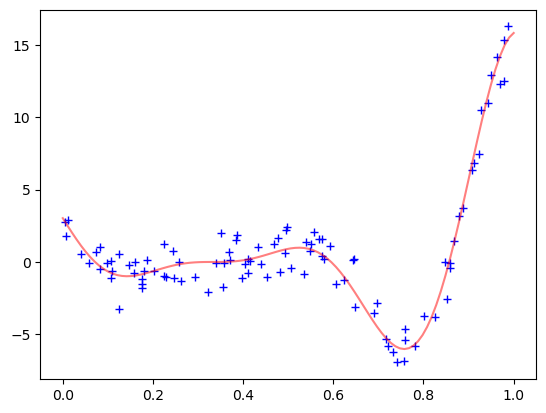

In [56]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data

plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

In [64]:
model1 = cigp(xtr, ytr)
model1.train_adam(200, 0.01, loss_type='eigen_nll')

iter 0, nll: 5088.41603
iter 10, nll: 1713.58241
iter 20, nll: 807.63820
iter 30, nll: 696.27488
iter 40, nll: 378.12791
iter 50, nll: 274.23555
iter 60, nll: 320.42088
iter 70, nll: 243.88868
iter 80, nll: 200.91616
iter 90, nll: 176.71323
iter 100, nll: 161.97788
iter 110, nll: 152.19265
iter 120, nll: 145.19397
iter 130, nll: 139.89477
iter 140, nll: 135.71103
iter 150, nll: 132.30560
iter 160, nll: 852.36109
iter 170, nll: 460.79617
iter 180, nll: 298.22301
iter 190, nll: 204.91892


In [65]:
model2 = cigp(xtr, ytr)
model2.train_adam(200, 0.01, loss_type='nll')

iter 0, nll: 122.53769
iter 10, nll: 116.11088
iter 20, nll: 109.16829
iter 30, nll: 102.26144
iter 40, nll: 95.79501
iter 50, nll: 89.89261
iter 60, nll: 84.52852
iter 70, nll: 79.64177
iter 80, nll: 75.13987
iter 90, nll: 70.92312
iter 100, nll: 66.91827
iter 110, nll: 63.08499
iter 120, nll: 59.40667
iter 130, nll: 55.88016
iter 140, nll: 52.50900
iter 150, nll: 49.29953
iter 160, nll: 46.25896
iter 170, nll: 43.39448
iter 180, nll: 40.71272
iter 190, nll: 38.21945


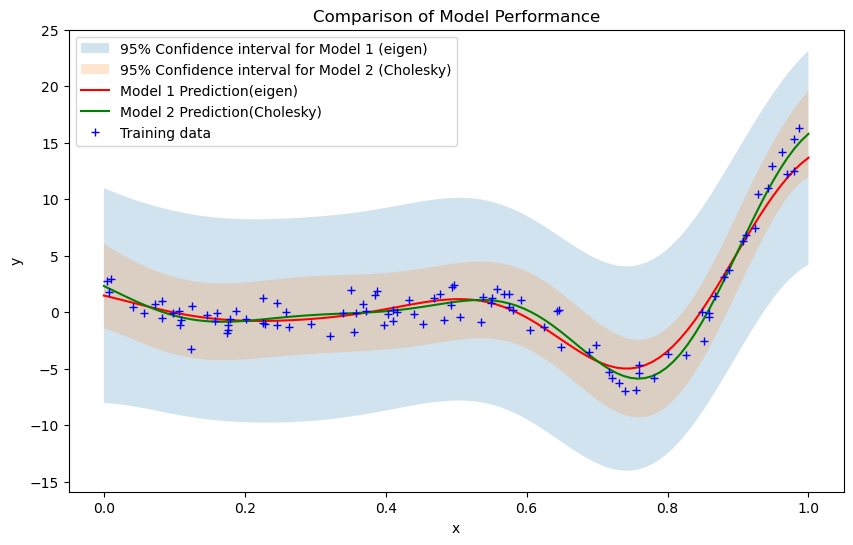

In [68]:
with torch.no_grad():
    ypred1, yvar1 = model1.forward(xte)
    ypred2, yvar2 = model2.forward(xte)
# Plot the results for both models
plt.figure(figsize=(10, 6))

# Plot predictions of the first model
plt.fill_between(xte.squeeze().numpy(),
                 ypred1.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar1.squeeze().detach().numpy()),
                 ypred1.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar1.squeeze().detach().numpy()), alpha=0.2,
                 label='95% Confidence interval for Model 1 (eigen)')
# Plot predictions of the second model
plt.fill_between(xte.squeeze().numpy(),
                 ypred2.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar2.squeeze().detach().numpy()),
                 ypred2.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar2.squeeze().detach().numpy()), alpha=0.2,
                 label='95% Confidence interval for Model 2 (Cholesky)')
plt.plot(xte.numpy(), ypred1.numpy(), 'r-', label='Model 1 Prediction(eigen)')
plt.plot(xte.numpy(), ypred2.numpy(), 'g-', label='Model 2 Prediction(Cholesky)')
# Plot training data points
plt.plot(xtr.numpy(), ytr.numpy(), 'b+', label='Training data')

# Add legend and labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Performance')
plt.show()

In [26]:
def calculate_mse(model, x_test, y_test):
    model.eval()  # 切换模型到评估模式
    with torch.no_grad():  # 关闭梯度计算
        y_pred, _ = model.forward(x_test)  # 获取模型预测输出
        mse_loss = nn.MSELoss()(y_pred, y_test)  # 计算 MSE
    return mse_loss.item()

In [17]:
print(calculate_mse(model1, xte, yte),
      calculate_mse(model2, xte, yte))

0.8535208702087402 0.26329904794692993
